# Predicting Stock Prices with LSTM
In this notebook, we will use the kaggle stocks dataset to train an lstm model for predicting stock prices. We will then use the predictions to make a basic trading signal and see how the portfolio utilizing this signal performs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Data loading and visualization
We first load the data for a company's stock prices. If you have the full dataset you can load any of the companies and try the remainder of the pipeline yourself.

In [2]:
path_to_data = "stock_data/stocks/"
companies = [f for f in os.listdir(path_to_data) if os.path.isfile(path_to_data + f)]
company = 'TGNA.csv'
print(company)

TGNA.csv


In [3]:
df = pd.read_csv(path_to_data + company)

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,2.339581,2.303252,2.303252,0.224802,197100.0
1,1980-03-18,0.0,2.383175,2.295986,2.383175,0.232603,688900.0
2,1980-03-19,0.0,2.412238,2.354112,2.383175,0.232603,555000.0
3,1980-03-20,0.0,2.383175,2.310517,2.310517,0.225511,302600.0
4,1980-03-21,0.0,2.325049,2.303252,2.303252,0.224802,372300.0


In order to keep consistent timelines and to not consider particularly old data, we will restrict all of our stock timeseries data to 2010 and more recent.

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > '2010-1-1']
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
7520,2010-01-04,7.831346,8.197541,7.721488,8.030138,5.235115,16230000.0
7521,2010-01-05,8.056294,8.574199,7.930742,8.495728,5.538649,17576000.0
7522,2010-01-06,8.459109,8.736371,8.427721,8.595124,5.603447,10920900.0
7523,2010-01-07,8.527117,8.840999,8.527117,8.830536,5.756920,11562300.0
7524,2010-01-08,8.752066,8.861924,8.684057,8.767759,5.715994,10226700.0


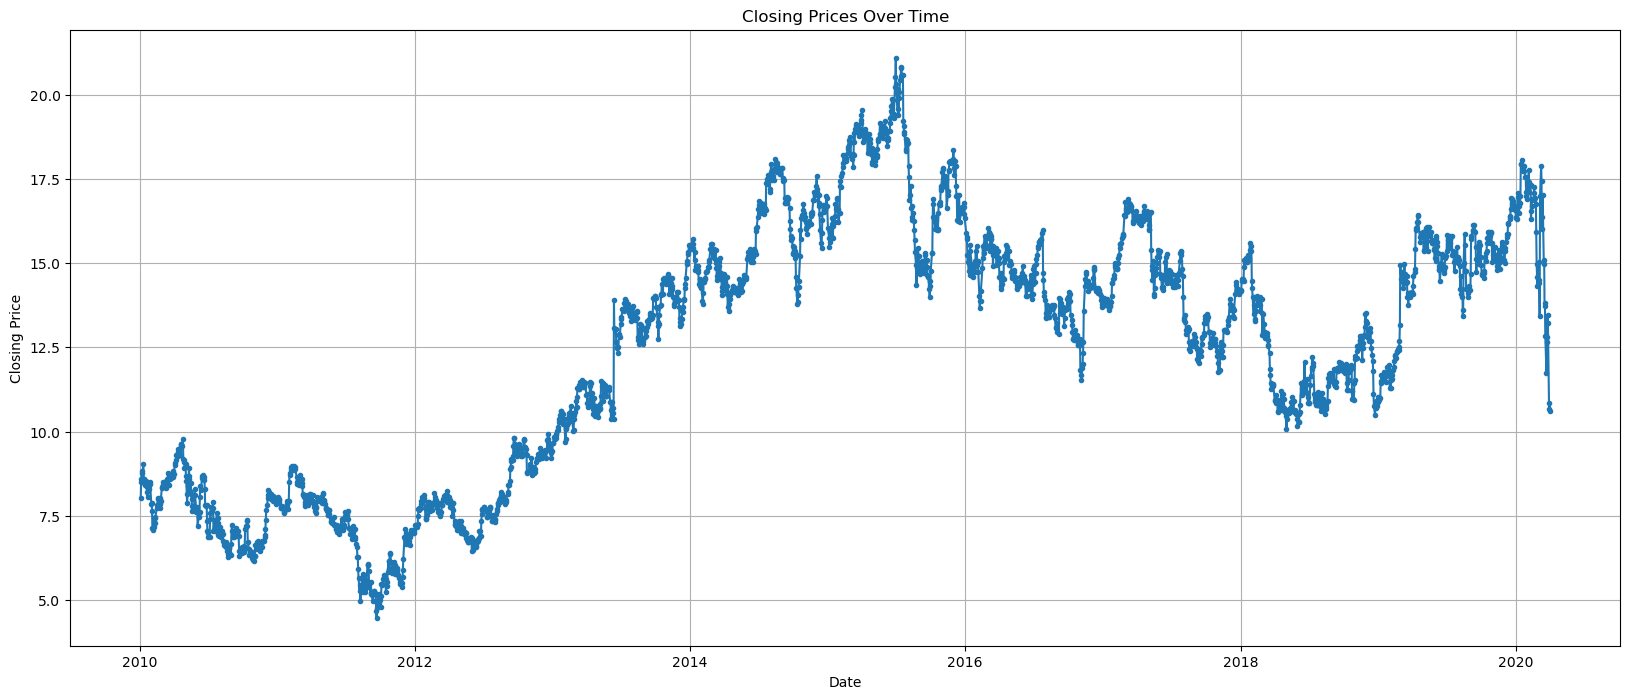

In [6]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

We extract the columns that we want to consider in our model. We also generate a new feature based on exponential moving averages.

In [7]:
new_df = df[['Open', 'High', 'Low', 'Close']].copy()
new_df['MVA'] = new_df['Close'].ewm(span=50, adjust=False).mean()
new_df.head()

,Open,High,Low,Close,MVA
7520,7.831346,8.197541,7.721488,8.030138,8.030138
7521,8.056294,8.574199,7.930742,8.495728,8.048396
7522,8.459109,8.736371,8.427721,8.595124,8.069837
7523,8.527117,8.840999,8.527117,8.830536,8.099668
7524,8.752066,8.861924,8.684057,8.767759,8.125868


## Model Development
Now we develop our model. We set num_timesteps = 30, which means in our model we will try to predict the closing price based on the data from the past 30 days.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [9]:
X = new_df[['Open','High','Low','Close','MVA']].to_numpy()
num_timesteps = 30

We scale the data and break it into training and testing data. We then fill in the train and test data.

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X.reshape(-1,1))
X = scaled_data.reshape(-1,5)

train_size = int(len(X) * 0.8) 
train_data, test_data = X[:train_size], X[train_size:]

In [11]:
X_train, y_train = [], []
for i in range(num_timesteps, len(train_data)):
    X_train.append(train_data[i - num_timesteps:i])
    y_train.append(train_data[i, 3])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(num_timesteps, len(test_data)):
    X_test.append(test_data[i - num_timesteps:i])
    y_test.append(test_data[i, 3])
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
print(X_train.shape), print(y_train.shape), print(X_test.shape), print(y_test.shape)

(2033, 30, 5)
(2033,)
(486, 30, 5)
(486,)


(None, None, None, None)

We now define the model. The model is a straightforward sequential model with an input later, three hidden LSTM layers with dropouts, and the output layer. The output of the model with a single input (being the previous 30 days of stock data) is the predicted closing price of the stock.

In [13]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [15]:
model.compile(loss='mean_squared_error',optimizer='adam')

We now train the model, saving the model at given checkpoints and allowing for early stopping criteria.

In [16]:
checkpoints = ModelCheckpoint(filepath='model_weights.h5', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.fit(X_train, y_train,
         validation_data=(X_test,y_test),
         epochs=100,
         batch_size=32,
         verbose=1,
         callbacks=[checkpoints, early_stopping])#, early_stopping])

Epoch 1/100

64/64 [==============================] - 8s 43ms/step - loss: 0.0131 - val_loss: 0.0029
Epoch 2/100
 4/64 [>.............................] - ETA: 1s - loss: 0.0044

C:\Users\natha\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 2s 26ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 3/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 5/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 6/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 7/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 8/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 9/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 10/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 11/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 12/1

Epoch 81/100
64/64 [==============================] - 2s 29ms/step - loss: 7.5636e-04 - val_loss: 5.8432e-04
Epoch 82/100
64/64 [==============================] - 2s 26ms/step - loss: 8.2882e-04 - val_loss: 0.0011
Epoch 83/100
64/64 [==============================] - 2s 26ms/step - loss: 8.2304e-04 - val_loss: 5.8850e-04
Epoch 84/100
64/64 [==============================] - 2s 26ms/step - loss: 7.7745e-04 - val_loss: 5.8356e-04
Epoch 85/100
64/64 [==============================] - 2s 26ms/step - loss: 8.2456e-04 - val_loss: 5.8655e-04
Epoch 86/100
64/64 [==============================] - 2s 26ms/step - loss: 7.0136e-04 - val_loss: 5.8297e-04
Epoch 87/100
64/64 [==============================] - 2s 25ms/step - loss: 7.4813e-04 - val_loss: 7.1290e-04
Epoch 88/100
64/64 [==============================] - 2s 25ms/step - loss: 7.8158e-04 - val_loss: 6.6979e-04
Epoch 89/100
64/64 [==============================] - 2s 25ms/step - loss: 7.8718e-04 - val_loss: 7.4365e-04
Epoch 90/100
64/64 [===

## Model Results
We now evaluate the model on both the train and test data.

In [17]:
train_predict = model.predict(X_train)
test_predict=model.predict(X_test)

16/16 [==============================] - 0s 7ms/step


In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
print(np.sqrt(mean_squared_error(y_train,train_predict)))
print(np.sqrt(mean_squared_error(y_test,test_predict)))

12.378682481465372
13.334655475629006


In [20]:
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

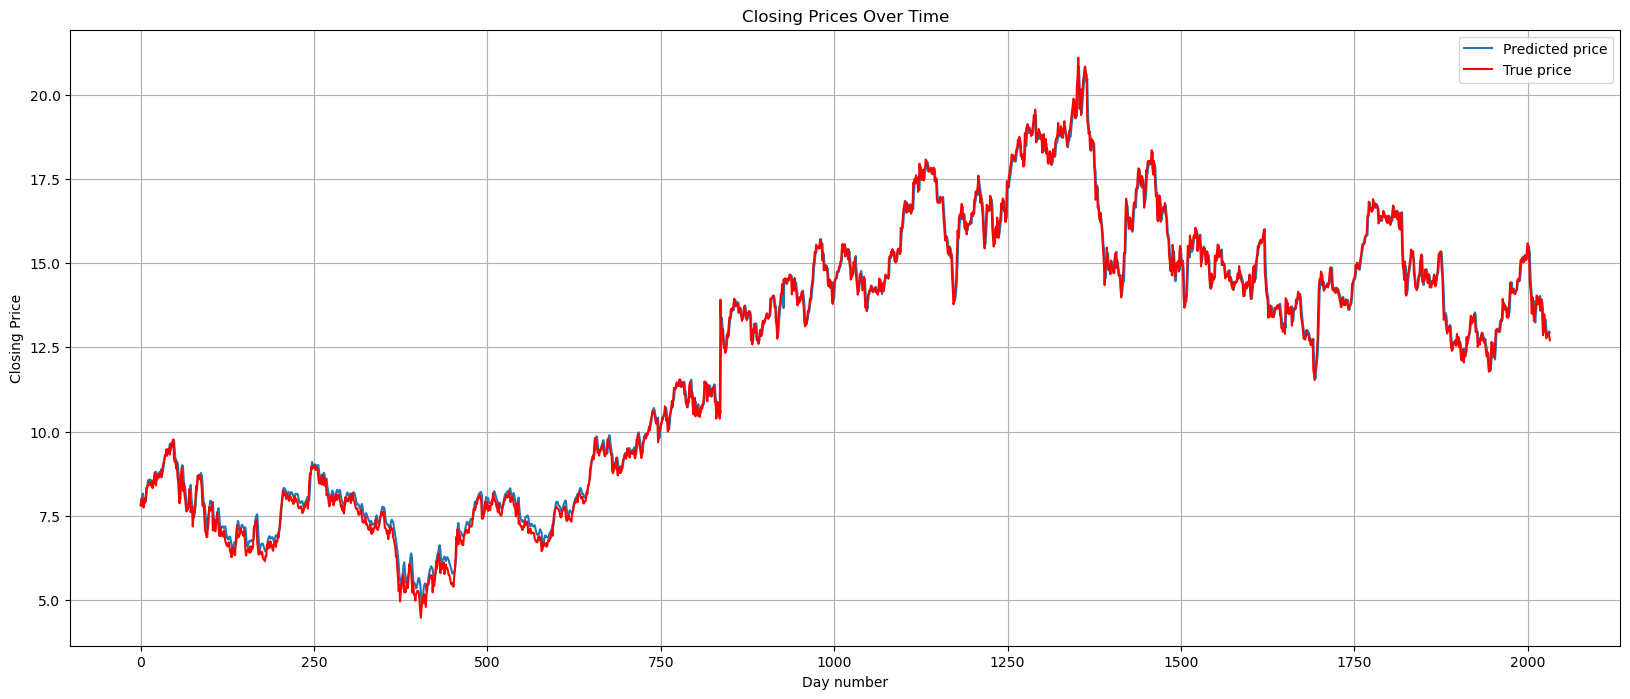

In [21]:
plt.figure(figsize=(20,8))
plt.plot(range(len(y_train)), train_predict, label='Predicted price')
plt.plot(range(len(y_train)), y_train, color='r', label='True price')
plt.title('Closing Prices Over Time')
plt.xlabel('Day number')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.show()

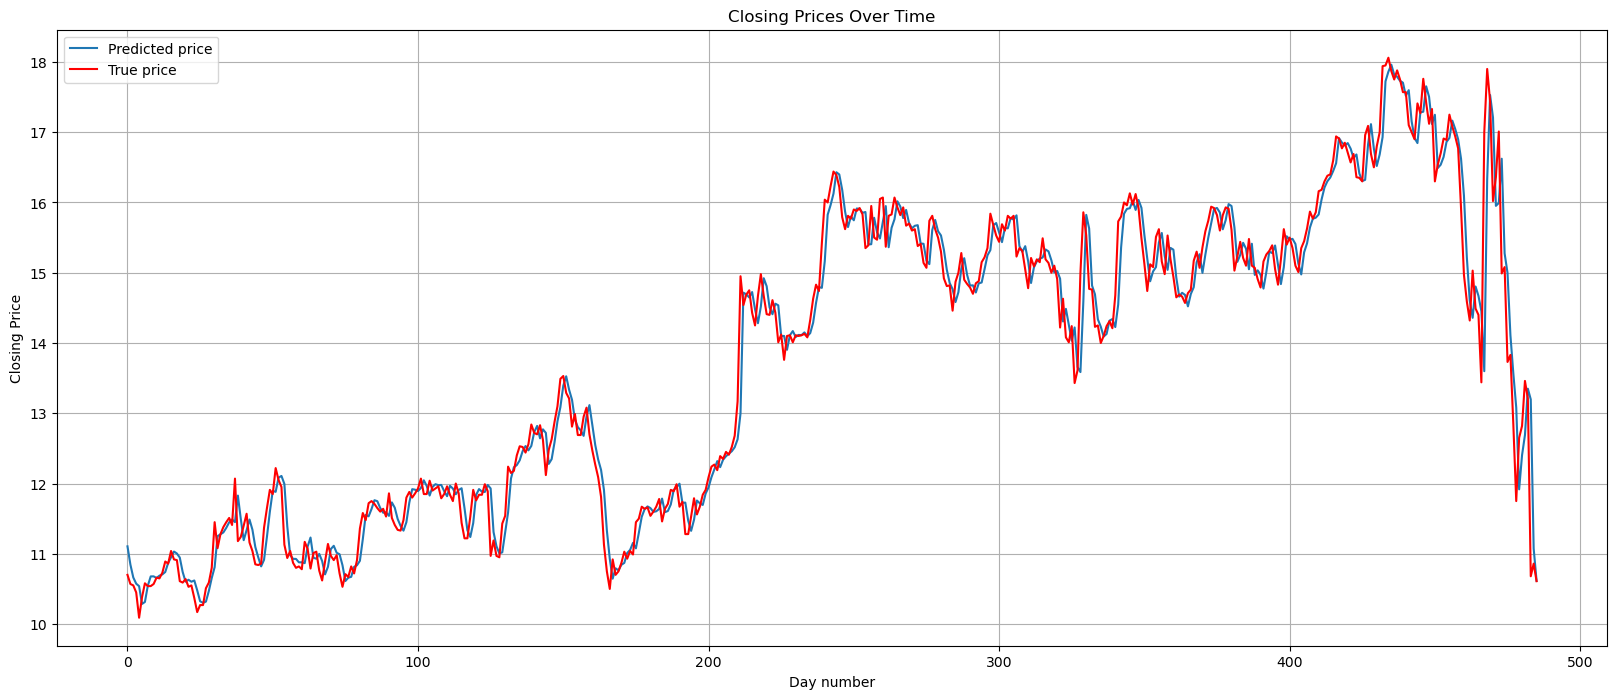

In [22]:
plt.figure(figsize=(20,8))
plt.plot(range(len(y_test)), test_predict, label='Predicted price')
plt.plot(range(len(y_test)), y_test, color='r', label='True price')
plt.title('Closing Prices Over Time')
plt.xlabel('Day number')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.show()

## Trading Signal 
We now use the model to develop a trading signal and play out a simulated portfolio based on this signal. The signal is very simple: if the model predicts that the price will go up the next day, buy as many shares as you can. If the model predicts that the price will go down the next day, sell all your shares.

In [23]:
truth = new_df[['Open','High','Low','Close','MVA']].to_numpy()

scaled_data = scaler.fit_transform(truth.reshape(-1,1))
truth = scaled_data.reshape(-1,5)
truth = truth[train_size:]
true_price = truth[:,3]

In [26]:
cash = [100000 for i in range(num_timesteps)]
shares = [0 for i in range(num_timesteps)]
assets = [100000 for i in range(num_timesteps)]

current_day = num_timesteps - 1

for i in range(len(true_price[num_timesteps:])):
    print(f"today is {current_day} and the current value is {assets[-1]}")
    current_day = int(i + num_timesteps)
    current_cash = cash[-1]
    current_shares = shares[-1]
    
    current_train = truth[current_day - num_timesteps:current_day]
    pred_price = model.predict(current_train[None,...])
    pred_price = scaler.inverse_transform(pred_price)
    pred_price = pred_price[0,0]

    day_price = scaler.inverse_transform(true_price[current_day-1].reshape(1,1))
    day_price = day_price[0,0]
    
    if pred_price < day_price:
        current_cash = current_cash + current_shares * day_price
        current_shares = 0
        cash.append(current_cash)
        shares.append(current_shares)
        assets.append(current_cash)
    else:
        buying = current_cash//day_price
        current_shares = current_shares + buying
        current_cash = current_cash - (buying * day_price)
        
        cash.append(current_cash)
        shares.append(current_shares)
        assets.append(current_shares * day_price + current_cash)


today is 29 and the current value is 100000
1/1 [==============================] - 0s 22ms/step
today is 30 and the current value is 100000.0
1/1 [==============================] - 0s 24ms/step
today is 31 and the current value is 97627.75791168213
1/1 [==============================] - 0s 23ms/step
today is 32 and the current value is 96441.63686752321
1/1 [==============================] - 0s 24ms/step
today is 33 and the current value is 96259.16139221191
1/1 [==============================] - 0s 22ms/step
today is 34 and the current value is 95346.75791168213
1/1 [==============================] - 0s 23ms/step
today is 35 and the current value is 92062.12104415894
1/1 [==============================] - 0s 26ms/step
today is 36 and the current value is 94708.08069610596
1/1 [==============================] - 0s 25ms/step
today is 37 and the current value is 94708.08069610596
1/1 [==============================] - 0s 24ms/step
today is 38 and the current value is 94708.08069610596
1/

1/1 [==============================] - 0s 23ms/step
today is 106 and the current value is 110854.71392631531
1/1 [==============================] - 0s 24ms/step
today is 107 and the current value is 110854.71392631531
1/1 [==============================] - 0s 25ms/step
today is 108 and the current value is 112413.05996322635
1/1 [==============================] - 0s 22ms/step
today is 109 and the current value is 112413.05996322635
1/1 [==============================] - 0s 24ms/step
today is 110 and the current value is 114405.39556312564
1/1 [==============================] - 0s 23ms/step
today is 111 and the current value is 114405.39556312564
1/1 [==============================] - 0s 21ms/step
today is 112 and the current value is 114405.39556312564
1/1 [==============================] - 0s 22ms/step
today is 113 and the current value is 114405.39556312564
1/1 [==============================] - 0s 23ms/step
today is 114 and the current value is 116797.00278568271
1/1 [==============

1/1 [==============================] - 0s 22ms/step
today is 181 and the current value is 125617.88727664958
1/1 [==============================] - 0s 23ms/step
today is 182 and the current value is 125617.88727664958
1/1 [==============================] - 0s 25ms/step
today is 183 and the current value is 124861.72799777993
1/1 [==============================] - 0s 22ms/step
today is 184 and the current value is 124861.72799777993
1/1 [==============================] - 0s 27ms/step
today is 185 and the current value is 126616.18167686471
1/1 [==============================] - 0s 23ms/step
today is 186 and the current value is 126616.18167686471
1/1 [==============================] - 0s 26ms/step
today is 187 and the current value is 126616.18167686471
1/1 [==============================] - 0s 24ms/step
today is 188 and the current value is 126616.18167686471
1/1 [==============================] - 0s 23ms/step
today is 189 and the current value is 127887.1927957536
1/1 [===============

1/1 [==============================] - 0s 24ms/step
today is 256 and the current value is 127073.37963294996
1/1 [==============================] - 0s 25ms/step
today is 257 and the current value is 127073.37963294996
1/1 [==============================] - 0s 22ms/step
today is 258 and the current value is 130212.94104194656
1/1 [==============================] - 0s 22ms/step
today is 259 and the current value is 130305.27434921276
1/1 [==============================] - 0s 25ms/step
today is 260 and the current value is 129381.87963294995
1/1 [==============================] - 0s 24ms/step
today is 261 and the current value is 130305.27434921276
1/1 [==============================] - 0s 26ms/step
today is 262 and the current value is 130212.94104194656
1/1 [==============================] - 0s 25ms/step
today is 263 and the current value is 130305.27434921276
1/1 [==============================] - 0s 25ms/step
today is 264 and the current value is 130489.95857620251
1/1 [==============

today is 331 and the current value is 143611.35404300716
1/1 [==============================] - 0s 24ms/step
today is 332 and the current value is 143611.35404300716
1/1 [==============================] - 0s 24ms/step
today is 333 and the current value is 143611.35404300716
1/1 [==============================] - 0s 22ms/step
today is 334 and the current value is 145544.40439415
1/1 [==============================] - 0s 23ms/step
today is 335 and the current value is 145544.40439415
1/1 [==============================] - 0s 24ms/step
today is 336 and the current value is 145544.40439415
1/1 [==============================] - 0s 27ms/step
today is 337 and the current value is 140205.4963178637
1/1 [==============================] - 0s 23ms/step
today is 338 and the current value is 141310.1040430072
1/1 [==============================] - 0s 24ms/step
today is 339 and the current value is 141310.1040430072
1/1 [==============================] - 0s 22ms/step
today is 340 and the current va

1/1 [==============================] - 0s 24ms/step
today is 407 and the current value is 143528.80107021373
1/1 [==============================] - 0s 25ms/step
today is 408 and the current value is 145552.79475307505
1/1 [==============================] - 0s 26ms/step
today is 409 and the current value is 145552.79475307505
1/1 [==============================] - 0s 24ms/step
today is 410 and the current value is 145370.05057048838
1/1 [==============================] - 0s 28ms/step
today is 411 and the current value is 142628.948827744
1/1 [==============================] - 0s 24ms/step
today is 412 and the current value is 137329.48952484177
1/1 [==============================] - 0s 26ms/step
today is 413 and the current value is 139156.88778209727
1/1 [==============================] - 0s 26ms/step
today is 414 and the current value is 141075.6581306462
1/1 [==============================] - 0s 27ms/step
today is 415 and the current value is 141075.6581306462
1/1 [==================

1/1 [==============================] - 0s 23ms/step
today is 482 and the current value is 148556.30376815842
1/1 [==============================] - 0s 22ms/step
today is 483 and the current value is 148556.30376815842
1/1 [==============================] - 0s 24ms/step
today is 484 and the current value is 148556.30376815842
1/1 [==============================] - 0s 24ms/step
today is 485 and the current value is 148556.30376815842
1/1 [==============================] - 0s 23ms/step
today is 486 and the current value is 151722.50913620042
1/1 [==============================] - 0s 22ms/step
today is 487 and the current value is 151722.50913620042
1/1 [==============================] - 0s 26ms/step
today is 488 and the current value is 151722.50913620042
1/1 [==============================] - 0s 26ms/step
today is 489 and the current value is 151722.50913620042
1/1 [==============================] - 0s 23ms/step
today is 490 and the current value is 151722.50913620042
1/1 [==============

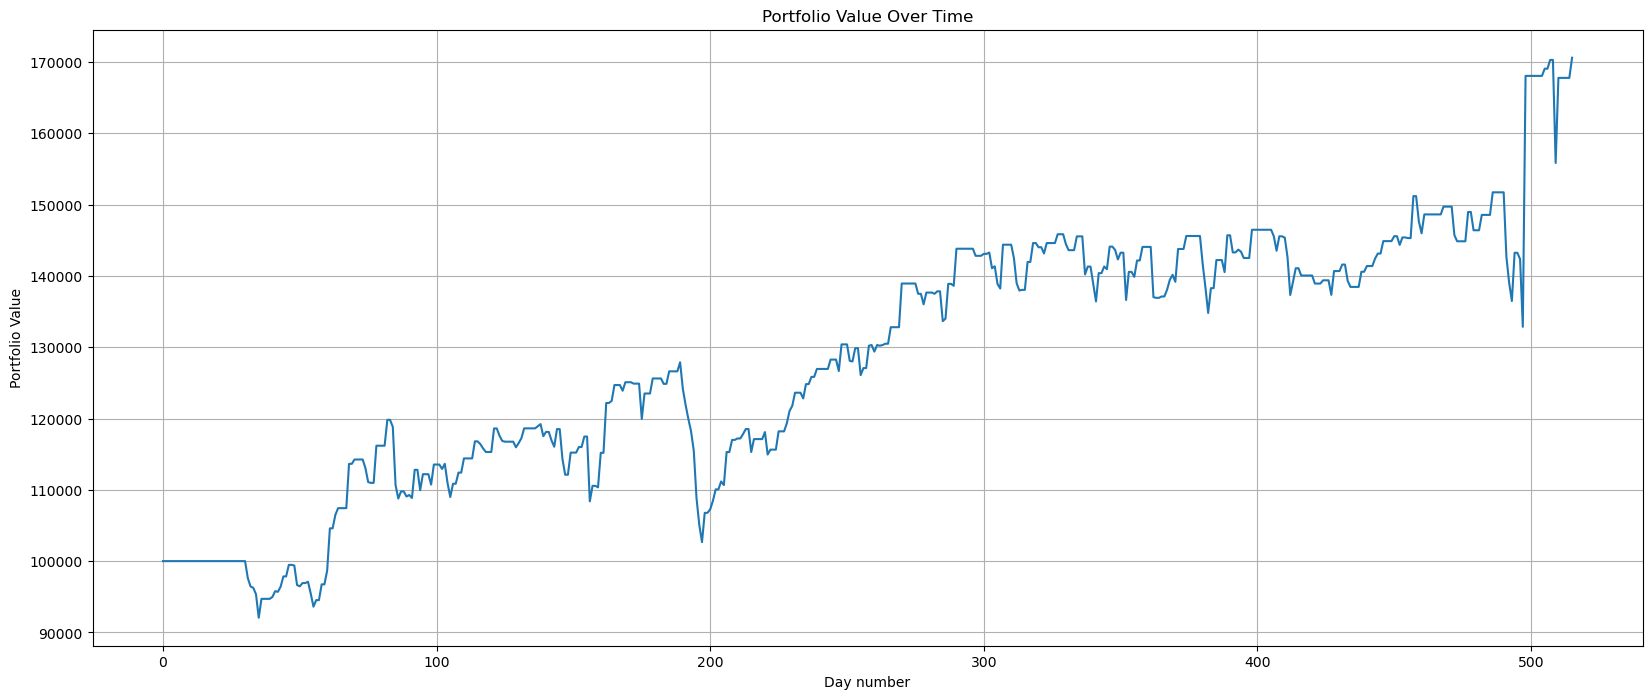

In [27]:
plt.figure(figsize=(20,8))
plt.plot(range(len(assets)), assets)
plt.title('Portfolio Value Over Time')
plt.xlabel('Day number')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

Perhaps a better way to track the quality of our trading signal is to look at multiplicative portfolio value vs multiplicative stock value.

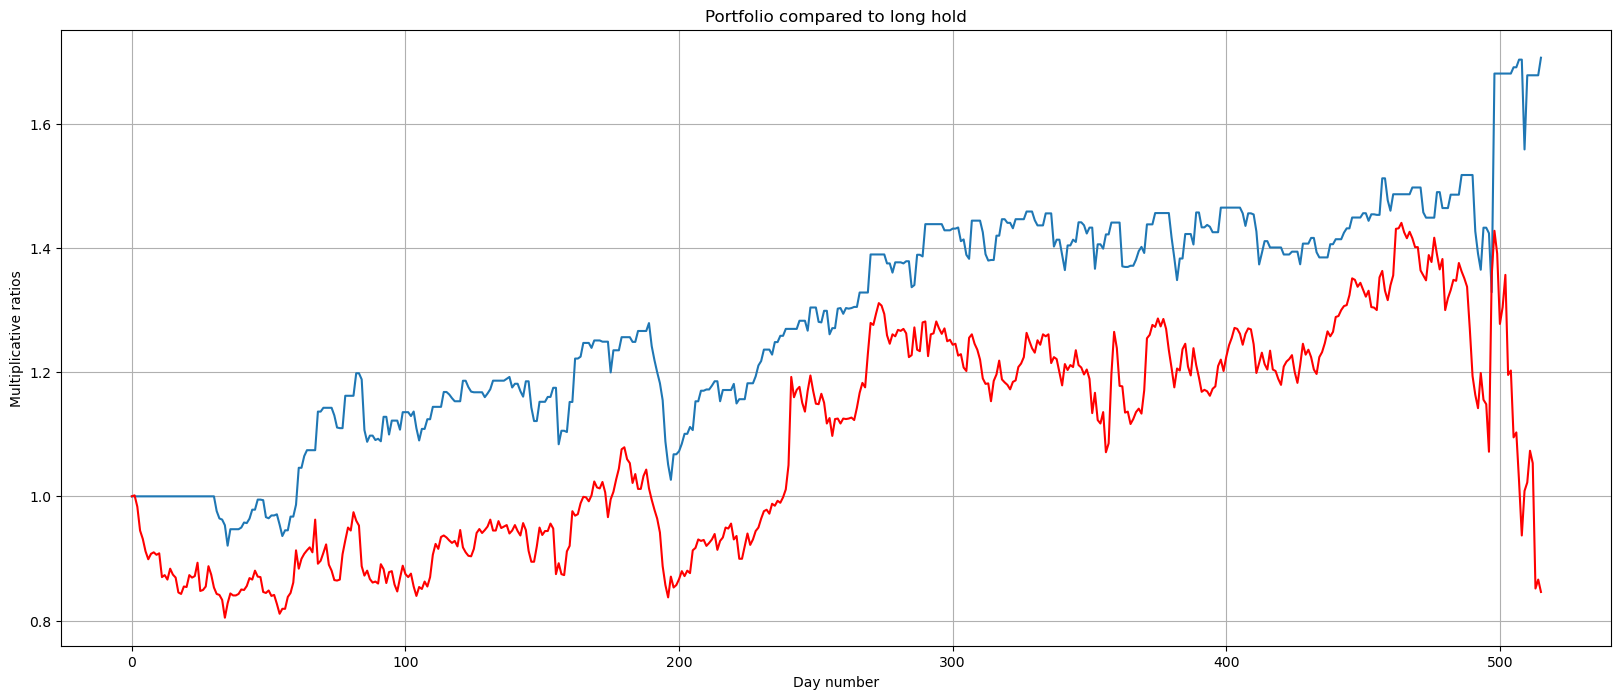

In [28]:
true_price = scaler.inverse_transform(true_price.reshape(-1,1))

plt.figure(figsize=(20,8))
plt.plot(range(len(assets)), np.array(assets)/100000, label='portfolio relative value')
plt.plot(range(len(assets)), true_price/true_price[0], color='r', label='true relative value')
plt.title('Portfolio compared to long hold')
plt.xlabel('Day number')
plt.ylabel('Multiplicative ratios')
plt.grid(True)
plt.show()

In [29]:
print((assets[-1]/100000)/(true_price[-1]/true_price[0]))
print(assets[-1]/100000)

[2.01633026]
1.7060018726444302


This value means that the value of our portfolio at the end of the time period is roughly 102% higher than if we had simply bought and held the stock from the beginning. In particular, we generated a positive 70.6% return on a timeperiod over which the total price of the stock actually dropped. The portfolio value looks like its most common issue is holding on to stocks when they are about to fall instead of cashing out. Future attempts at tuning the trading signal may include accounting for further factors to warn away from holding on to stock if the price may decrease, such as taking into account more than just the prediction for the next one day.